In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from methods import load_data, NeuralNet, loader_eval, load_data_with_validation

In [11]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size =     100
learning_rate = 0.001


# Define subset sizes
train_subset_size = 6000
test_subset_size = 6000


In [12]:
# MNIST dataset
full_train_dataset = torchvision.datasets.MNIST(root='./data/',
                                                train=True,
                                                transform=transforms.ToTensor(),
                                                download=True)
full_test_dataset = torchvision.datasets.MNIST(root='./data/',
                                               train=False,
                                               transform=transforms.ToTensor())

# Create subsets of train and test datasets
train_subset = torch.utils.data.Subset(full_train_dataset, range(train_subset_size))
test_subset = torch.utils.data.Subset(full_test_dataset, range(test_subset_size))

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_subset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_subset,
                                          batch_size=batch_size,
                                          shuffle=False)


In [13]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    # Train
    # model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [14]:
weights = model.state_dict()['fc1.weight']
bias = model.state_dict()['fc1.bias']

In [15]:
def compute_zi(xi,W, b):
    zi = torch.matmul(xi, W.t()) + b
    # implement the ReLu function on zi
    zi = nn.ReLU()(zi)
    return zi

In [16]:
Z = []
X = []
labels = []
for i in range(train_subset_size):
    xi = train_subset[i][0].reshape(-1, input_size).to(device)
    X.append(xi.cpu().detach().numpy()[0])
    labels.append(train_subset[i][1])
    zi = compute_zi(xi, weights, bias)
    Z.append(zi.cpu().detach().numpy()[0])

In [17]:
Z = np.array(Z)
labels = np.array(labels)
X = np.array(X)

In [19]:
Z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(Z)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)

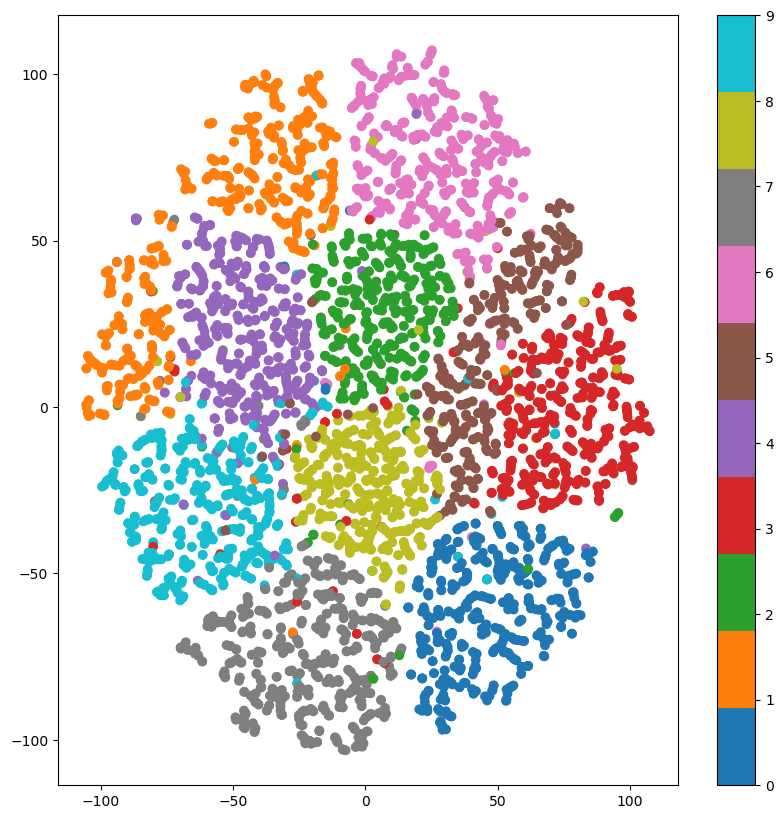

In [20]:
#plot Z_embedded
plt.figure(figsize=(10,10))
plt.scatter(Z_embedded[:,0], Z_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

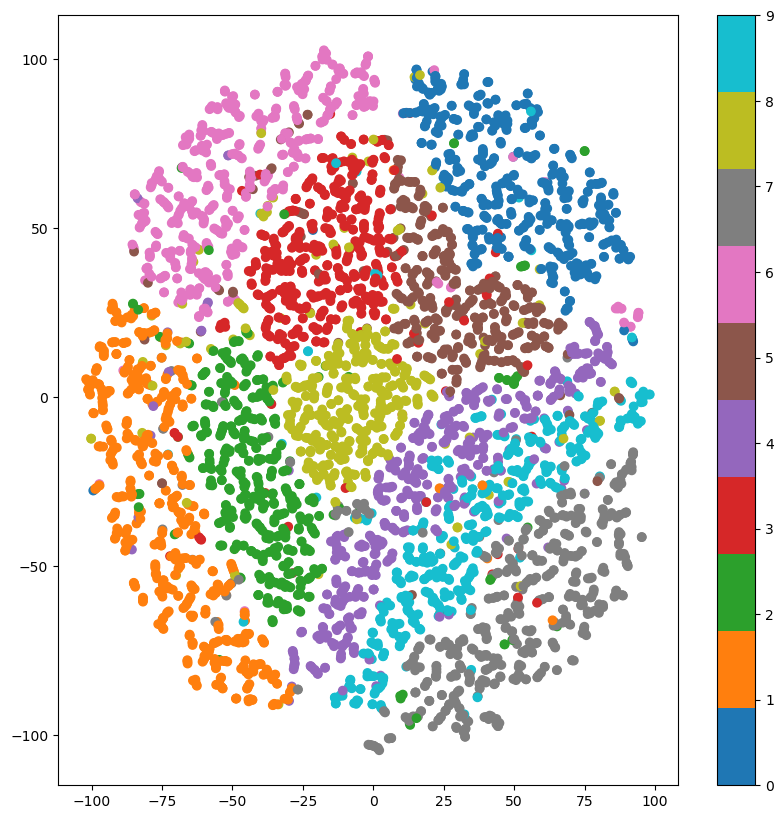

In [21]:

#plot X_embedded
plt.figure(figsize=(10,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()